In [1]:
from env.env_v1 import SpatialSpreadEnv
import os
from copy import deepcopy
import numpy as np
import supersuit as ss
import torch
from tqdm import trange

from agilerl.algorithms.core.registry import HyperparameterConfig, RLParameter
from agilerl.algorithms.maddpg import MADDPG
from agilerl.components.multi_agent_replay_buffer import MultiAgentReplayBuffer
from agilerl.utils.utils import create_population, observation_space_channels_to_first
from agilerl.vector.pz_async_vec_env import AsyncPettingZooVecEnv

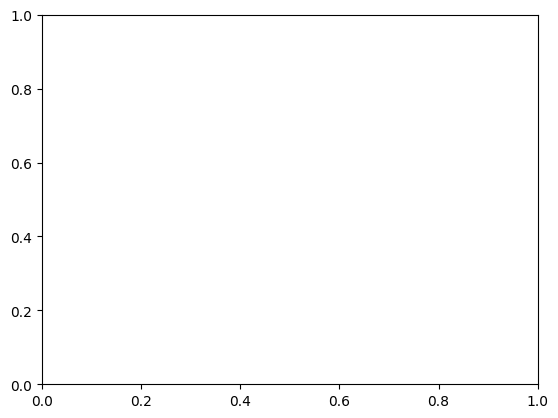

In [2]:
pretrained = "./models/MADDPG/Jul12_I.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# pretrained_agents = MADDPG.load(pretrained, device)

NET_CONFIG = {
  "encoder_config": {'hidden_size': [32, 32]}, 
  "head_config": {'hidden_size': [32]}     
}
INIT_HP = {
    "POPULATION_SIZE": 3,
    "ALGO": "MADDPG",
    "CHANNELS_LAST": False,
    "BATCH_SIZE": 64,
    "O_U_NOISE": True,
    "EXPL_NOISE": 0.1,
    "MEAN_NOISE": 0.0,
    "THETA": 0.15,
    "DT": 0.01,
    "LR_ACTOR": 0.0005,
    "LR_CRITIC": 0.0005,
    "GAMMA": 0.98,
    "MEMORY_SIZE": 200000,
    "LEARN_STEP": 50,
    "TAU": 0.01,
}
num_envs = 8
env  = SpatialSpreadEnv()
env = AsyncPettingZooVecEnv([lambda: env for _ in range(num_envs)])
env.reset()
observation_spaces = [env.single_observation_space(agent) for agent in env.agents[:3]]
action_spaces = [env.single_action_space(agent) for agent in env.agents[:3]]
INIT_HP["AGENT_IDS"] = env.agents[:3]
hp_config = HyperparameterConfig(
    lr_actor=RLParameter(min=1e-4, max=1e-2),
    lr_critic=RLParameter(min=1e-4, max=1e-2),
    batch_size=RLParameter(min=16, max=128, dtype=int),
    learn_step=RLParameter(min=50, max=200, dtype=int, grow_factor=1.5, shrink_factor=0.75),
)
agent: MADDPG = create_population(
    INIT_HP["ALGO"],
    observation_spaces,
    action_spaces,
    NET_CONFIG,
    INIT_HP,
    hp_config,
    population_size=INIT_HP["POPULATION_SIZE"],
    num_envs=num_envs,
    device=device,
)[0]
field_names = ["obs", "action", "reward", "next_obs", "done"]
memory = MultiAgentReplayBuffer(
    INIT_HP["MEMORY_SIZE"],
    field_names=field_names,
    agent_ids=INIT_HP["AGENT_IDS"],
    device=device,
)
agent_ids = deepcopy(env.agents[:3])
max_steps = 2400*15 # 30
learning_delay = 100
training_steps = 2400
eval_steps = None
eval_loop = 1
total_steps = 0

In [3]:
import random
data = np.load('result/action_list.npz', allow_pickle=True)
action_list = data['action_list'].tolist()

In [4]:
print("Training...")
keys = ['agent_0', 'agent_1', 'agent_2']
pbar = trange(max_steps, unit="step")
while np.less(agent.steps[-1], max_steps):
    obs, info = env.reset()
    obs_s = {k: obs[k] for k in keys}
    info_s = {k: info[k] for k in keys}
    scores = np.zeros((num_envs, len(agent_ids))) ## solved
    completed_episode_scores = []
    steps = 0

    for idx_step in range(training_steps // num_envs):
        cont_actions_s, discrete_action_s = agent.get_action(obs=obs_s, training=True, infos=info_s)
        action_new = discrete_action_s if agent.discrete_actions else cont_actions_s
        ''' Tricky Here'''
        # action = {f'agent_{i}': np.full(8, np.random.randint(0, 4)) for i in range(env.num_agents)} 
        action = action_list[idx_step]
        for i, key in enumerate(list(action.keys())[:3]):
            action[key] = action_new[key]
        next_obs, reward, termination, truncation, info = env.step(action)
        next_obs_s = {k: next_obs[k] for k in keys}
        reward_s = {k: reward[k] for k in keys}
        termination_s = {k: termination[k] for k in keys}
        truncation_s = {k: truncation[k] for k in keys}
        info_s = {k: info[k] for k in keys}
        if not truncation:
            assert False
        scores += np.array(list(reward_s.values())).reshape(num_envs, len(agent_ids))
        total_steps += num_envs
        steps += num_envs
        ''' ?? why not discrete '''
        memory.save_to_memory(obs_s, cont_actions_s, reward_s, next_obs_s, truncation_s, is_vectorised=True)

        if memory.counter > learning_delay and len(memory) >= agent.batch_size:
            if agent.learn_step > num_envs:
                learn_step = agent.learn_step // num_envs
                if idx_step % learn_step == 0:
                    experiences = memory.sample(agent.batch_size)
                    agent.learn(experiences)
            else:
                for _ in range(num_envs // agent.learn_step):
                    experiences = memory.sample(agent.batch_size)
                    agent.learn(experiences)

        obs = next_obs
        obs_s = next_obs_s

        reset_noise_indices = []
        term_array = np.array(list(termination_s.values())).transpose()
        trunc_array = np.array(list(truncation_s.values())).transpose()
        for idx, (d, t) in enumerate(zip(term_array, trunc_array)):
            if np.any(d) or np.any(t):
                completed_episode_scores.append(scores[idx])
                agent.scores.append(scores[idx])
                scores[idx] = 0
                reset_noise_indices.append(idx)
        agent.reset_action_noise(reset_noise_indices)

    pbar.update(training_steps)
    agent.steps[-1] += steps
    agent.steps.append(agent.steps[-1])

path = "./models/MADDPG"
filename = "MADDPG_trained_agent.pt"
os.makedirs(path, exist_ok=True)
save_path = os.path.join(path, filename)
agent.save_checkpoint(save_path)
pbar.close()
env.close()

Training...


100%|██████████████████████████████████████████████████████████████| 36000/36000 [03:28<00:00, 172.33step/s]


In [5]:
!python3 Inference_As.py

Checkpoint:  {'O_U_noise': True, 'action_dims': (np.int64(4), np.int64(4), np.int64(4)), 'action_space': Dict('agent_0': Discrete(4), 'agent_1': Discrete(4), 'agent_2': Discrete(4)), 'action_spaces': [Discrete(4), Discrete(4), Discrete(4)], 'agent_ids': ['agent_0', 'agent_1', 'agent_2'], 'algo': 'MADDPG', 'batch_size': 64, 'criterion': MSELoss(), 'current_noise': [tensor([[ 0.1119,  0.1355,  0.1675,  0.0590],
        [ 0.1841, -0.0778,  0.0783,  0.0656],
        [-0.1250,  0.1637, -0.0645, -0.0574],
        [-0.0746,  0.1274, -0.2289, -0.1201],
        [-0.1500, -0.1755, -0.1727, -0.1288],
        [ 0.0092,  0.2611,  0.0359, -0.1798],
        [ 0.0546,  0.0893, -0.0005, -0.2218],
        [ 0.1212,  0.3837,  0.0265,  0.1213]], device='cuda:0'), tensor([[ 0.0636, -0.2619, -0.0458, -0.3587],
        [ 0.0166,  0.0273,  0.0199, -0.0055],
        [-0.2853, -0.3053, -0.0586, -0.1727],
        [-0.0664, -0.0690, -0.1402, -0.0206],
        [-0.0125, -0.0054, -0.1333,  0.0019],
        [-0.2048